In [1]:
# Fix for MPS (Apple Silicon) compatibility
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
from fastbook import *
from fastai.vision.widgets import *

/Users/joaomarcosribeirotiburcio/Projects/string_instrument_classifier/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
from ddgs import DDGS

def search_images_duckduckgo(query, max_results=10):
    """
    Search for images using DuckDuckGo with pagination to get more than 100 results
    """
    all_images = []
    page = 0
    
    try:
        with DDGS() as ddgs:
            while len(all_images) < max_results:
                # Each page returns up to 100 results
                results = list(ddgs.images(query, max_results=100, page=page))
                
                if not results:  # No more results
                    break
                
                # Add new images (avoid duplicates)
                for result in results:
                    if result["image"] not in all_images:
                        all_images.append(result["image"])
                        if len(all_images) >= max_results:
                            break
                
                page += 1
                
                # Safety break to avoid infinite loops
                if page > 10:  # Max 10 pages (1000 results)
                    break
                    
    except Exception as e:
        print(f"Error searching images: {e}")
    
    return all_images[:max_results]
    

In [4]:
ims = search_images_duckduckgo('piano', max_results=1)

dest = 'images/piano.jpg'
download_url(ims[0], dest)

Path('images/piano.jpg')

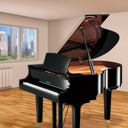

In [5]:
im = Image.open(dest)
im.to_thumb(128,128)

In [6]:
string_instrument_types = 'violin','cello','acoustic guitar','electric guitar','piano','ukulele'
path = Path('string_instruments')

In [40]:
if not path.exists():
    path.mkdir()
    for o in string_instrument_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_duckduckgo(o, 100)
        download_images(dest, urls=results)

In [41]:
fns = get_image_files(path)
fns

(#530) [Path('string_instruments/piano/cb6d4edc-e42e-4ae8-b375-b55452c68930.png'),Path('string_instruments/piano/2c7fbb67-7634-4ffe-b82f-64ac6acf0e42.jpg'),Path('string_instruments/piano/b1cd447b-450c-4b42-8a3b-6598f7d28e26.jpg'),Path('string_instruments/piano/33e24f1a-11f1-459f-9953-bfdf097747ec.png'),Path('string_instruments/piano/653aebb8-dc26-4dd3-b595-50a11845646d.jpg'),Path('string_instruments/piano/466a9048-d9d3-4821-a29e-91b5be597744.jpg'),Path('string_instruments/piano/fac20dfa-a26c-4e5c-8da0-6f37929bb6b0.jpg'),Path('string_instruments/piano/372ff5ad-e67e-425e-b889-d06e9a1f080b.jpg'),Path('string_instruments/piano/a4ac126f-a5bd-4751-96ce-41fa1f3cfeb7.gif'),Path('string_instruments/piano/4ef83de7-4ef8-4310-a291-a019b04bbee8.jpg'),Path('string_instruments/piano/dd10318a-5314-4684-b0bd-f26f3f3ffb65.jpg'),Path('string_instruments/piano/4c632273-db80-454d-b540-fd69b544847c.jpg'),Path('string_instruments/piano/41952d00-6b69-41af-b777-84db84fa5832.jpg'),Path('string_instruments/piano

In [42]:
failed = verify_images(fns)
failed

(#5) [Path('string_instruments/piano/e853638e-96cd-4c21-acde-807a5cfb8faa.jpg'),Path('string_instruments/piano/e0ee5d5f-7b87-4771-8b88-d6b5f6aa2e09.png'),Path('string_instruments/cello/d4e4daf0-7688-45a4-addc-5e774b5ac212.jpeg'),Path('string_instruments/acoustic guitar/033f85fc-edfb-4c5d-b511-c9f48071a147.jpg'),Path('string_instruments/ukulele/811caec4-fe7c-42ba-9c9a-9d6041586af2.jpg')]

In [43]:
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

In [44]:
musical_instruments = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [45]:
dls = musical_instruments.dataloaders(path)

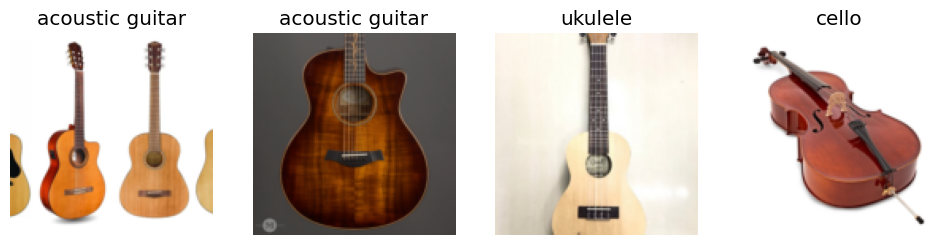

In [46]:
dls.valid.show_batch(max_n=4, nrows=1)

In [47]:
musical_instruments = musical_instruments.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = musical_instruments.dataloaders(path)

In [48]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.509641,1.105542,0.390476,00:10


/Users/joaomarcosribeirotiburcio/Projects/string_instrument_classifier/venv/lib/python3.9/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,1.060838,0.739296,0.257143,00:11
1,0.858799,0.536399,0.200000,00:11
2,0.648907,0.475083,0.161905,00:11
3,0.541206,0.468886,0.161905,00:11


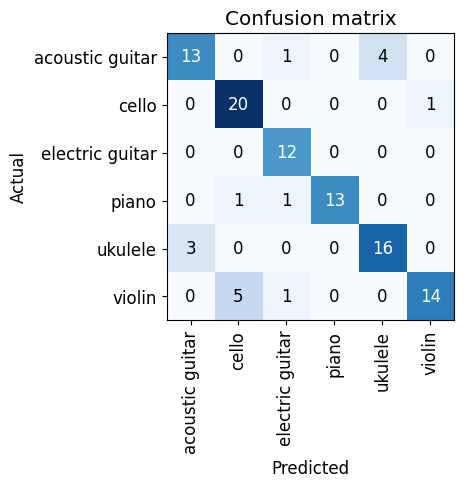

In [49]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

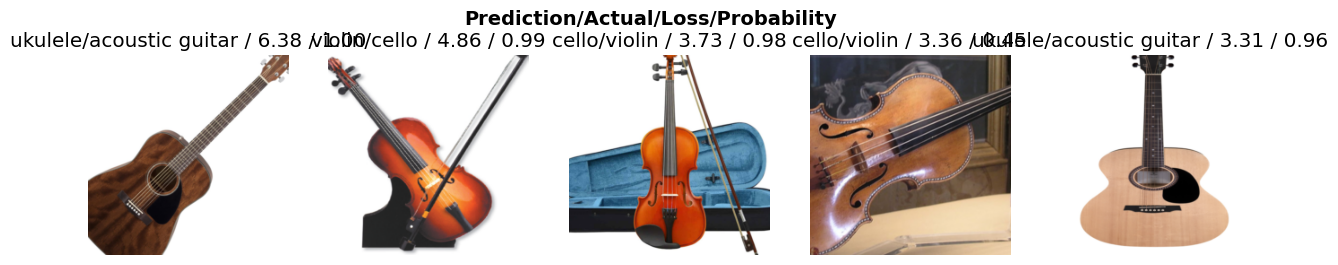

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [51]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/Users/joaomarcosribeirotiburcio/Projects/string_instrument_classifier/venv/lib/python3.9/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [52]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [56]:
musical_instruments = musical_instruments.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = musical_instruments.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.414456,0.841413,0.307692,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.087205,0.593648,0.230769,00:11
1,0.892298,0.532857,0.192308,00:11
2,0.706560,0.435855,0.163462,00:11
3,0.573774,0.395665,0.144231,00:11
4,0.508870,0.363648,0.134615,00:10


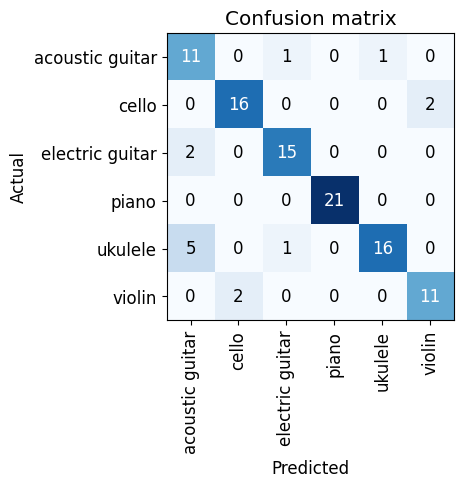

In [57]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

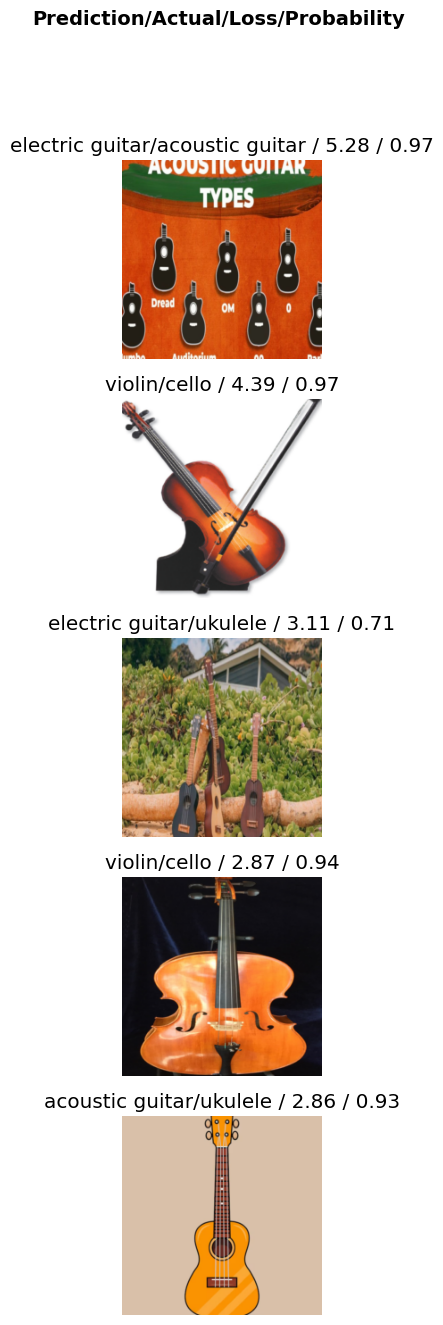

In [60]:
interp.plot_top_losses(5, nrows=5)